In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [2]:
# Load csv file and count not null values for each field.


df_outofhome = pd.read_csv('OutOfHome_batch2.csv').replace("\\N",np.nan)

df_outofhome['snapshot_url_1'] = df_outofhome['snapshot_url_1'].apply(lambda x: x.split('?')[0])

df_outofhome['purchase_total'] = pd.to_numeric(df_outofhome['purchase_total'])
df_outofhome['summed_net_total'] = pd.to_numeric(df_outofhome['summed_net_total'])

df_outofhome['total_diff'] = abs(df_outofhome['purchase_total'] - df_outofhome['summed_net_total'])/df_outofhome['purchase_total']


    
    
    

# Unified dataframe SmartScan and OutOfHome
df = df_outofhome
# df = df[['file','client_receipt_id','handle_id','flaw_POOR_DIMENSION','retailer_name','purchase_date','purchase_time','purchase_total','store_phone']]

# df[(df['total_diff'] != 0) & (df['total_diff'].notnull())].transpose()
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054
id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.53299e+07,1.53301e+07,1.53303e+07,1.53303e+07,1.53304e+07,1.53305e+07,1.53306e+07,1.53306e+07,1.53311e+07,1.53311e+07
file,out_of_home2,out_of_home2,out_of_home2,out_of_home2,out_of_home2,out_of_home2,out_of_home2,out_of_home2,out_of_home2,out_of_home2,...,out_of_home2,out_of_home2,out_of_home2,out_of_home2,out_of_home2,out_of_home2,out_of_home2,out_of_home2,out_of_home2,out_of_home2
client_receipt_id,OOHReceipt_20200124_182758,OOHReceipt_20200124_203317,OOHReceipt_20200124_094925,OOHReceipt_20200124_203030,OOHReceipt_20200122_141354,OOHReceipt_20200121_152314,OOHReceipt_20200120_204540,OOHReceipt_20200122_124014,OOHReceipt_20200122_172725,OOHReceipt_20200120_154655,...,OOHReceipt_20200120_123455,OOHReceipt_20200127_114018,OOHReceipt_20200122_201945,OOHReceipt_20200122_201945,OOHReceipt_20200124_120327,OOHReceipt_20200122_132122,OOHReceipt_20200120_160024,OOHReceipt_20200123_120558,OOHReceipt_20200127_191006,OOHReceipt_20200127_191006
snapshot_url_1,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200124_182758_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200124_203317_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200124_094925_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200124_203030_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200122_141354_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200121_152314_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200120_204540_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200122_124014_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200122_172725_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200120_154655_1.jpg,...,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200120_123455_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200127_114018_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200122_201945_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200122_201945_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200124_120327_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200122_132122_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200120_160024_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200123_120558_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200127_191006_1.jpg,https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200127_191006_1.jpg
handle_id,4d0a8b43-b81d-42c9-aa27-76978b745503,2f3e09f8-11e7-44d7-947a-7dc33377c6f7,cf2a2c60-ce6a-4be6-8dff-79c4082149c4,b2b60530-4bf4-465a-a875-7e175f52efea,e15db52e-1e1f-4fe0-a4aa-a80c889d828d,0e951d19-a900-47a2-a0a0-838ddb4a27d1,61cb5181-b6bd-4256-a6d5-9fa8440e77aa,0b016e55-f6f8-4402-a75e-fc01336d4578,ced290a7-8345-47e5-9973-4510d9c5e0d8,e224a21c-e372-4e2b-9b9f-40b52a157f3e,...,bff43ae2-412e-4d81-bfa5-1d777e291f08,87ee10f5-5317-4f36-85f5-072e486880e4,3fec64bf-ddde-4458-836e-0c91d952346a,3fec64bf-ddde-4458-836e-0c91d952346a,3af0f88f-c832-427b-8fa5-cb18d4aa6769,a8352cb7-ffce-4da5-9808-f9fe0f8e60c5,e6df5168-560e-4276-8487-670197f973c1,ce3d25e8-6f4d-43d2-b364-e69136f76599,66a88444-0610-4049-8e25-42b4c2497a35,66a88444-06

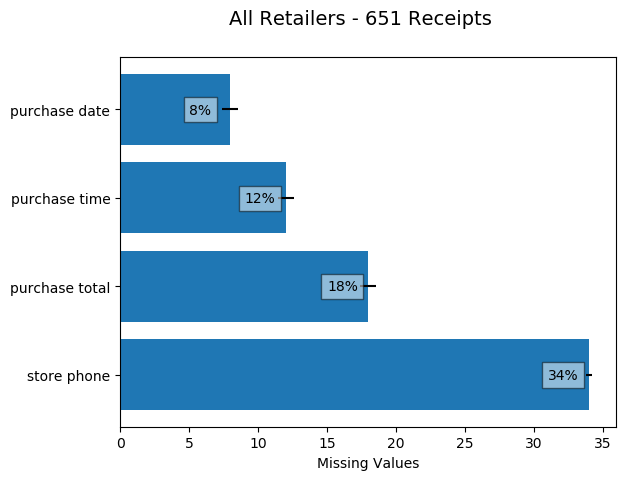

In [3]:

#  Calculate % of missing values for each field, e.g missing_purchase_date etc..
receipts = df[['file',
               'client_receipt_id',
               'handle_id',
               'retailer_name',
               'purchase_date',
               'purchase_time',
               'purchase_total',
               'store_phone'
               ]]

receipts = receipts.copy().groupby('client_receipt_id').first()
total_receipts = receipts.shape[0]

receipts_missing_values = round(((receipts.isna().sum() / total_receipts))*100).astype(int)


#  Plot % of missing values
plt.rcdefaults()
fig, ax = plt.subplots()
fig.suptitle(('All Retailers - ' + str(total_receipts) + ' Receipts'), fontsize=14)


key = receipts_missing_values.keys()[3:]
key = key.str.replace('_',' ').map(lambda x: x.lower())

y_pos = np.arange(len(key))
performance = receipts_missing_values[3:]
error = np.random.rand(len(key))

ax.barh(y_pos, performance.values, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(key)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Missing Values')


for i, v in enumerate(performance.values):
    ax.text(max(2,v-3), i + .05, str(v)+'%', bbox=dict(facecolor='white', alpha=0.5))
    
    
plt.savefig('All_retailers.png', bbox_inches='tight', transparent=True)
plt.show()

In [4]:
df_receipts_quality = pd.read_csv('receipts_quality.csv')
df_outofhome = df.copy()
df_outofhome = df_outofhome.merge(df_receipts_quality, on='client_receipt_id' , how="left")

df_outofhome_poor = df_outofhome[df_outofhome['quality']=='poor'].iloc[:,:-1]
df_outofhome_ok = df_outofhome[df_outofhome['quality']=='good'].iloc[:,:-1]


receipts_ok = df_outofhome_ok.copy().groupby('client_receipt_id').first()


receipts_total_diff = df_outofhome_ok[['file',
               'client_receipt_id',
               'total_diff'
               ]]

receipts_total_diff = receipts_total_diff.copy().groupby('client_receipt_id').first()
receipts_total_diff['diff_missing'] = receipts_total_diff['total_diff'].isnull()
receipts_total_diff['diff_1+'] = receipts_total_diff['total_diff']>=1
receipts_total_diff['diff_0-1'] = (receipts_total_diff['total_diff']<1) & (receipts_total_diff['total_diff']>0.0)
receipts_total_diff['diff_0'] = receipts_total_diff['total_diff']==0.0


total_receipts = receipts_ok.shape[0]

receipts_total_diff.head()

print('diff_missing: ',round(receipts_total_diff['diff_missing'].sum()/total_receipts*100),'%')
print('diff_1+: ',round(receipts_total_diff['diff_1+'].sum()/total_receipts*100),'%')
print('diff_0-1: ',round(receipts_total_diff['diff_0-1'].sum()/total_receipts*100),'%')
print('diff_0: ',round(receipts_total_diff['diff_0'].sum()/total_receipts*100),'%')

diff_missing:  12.0 %
diff_1+:  5.0 %
diff_0-1:  7.0 %
diff_0:  76.0 %


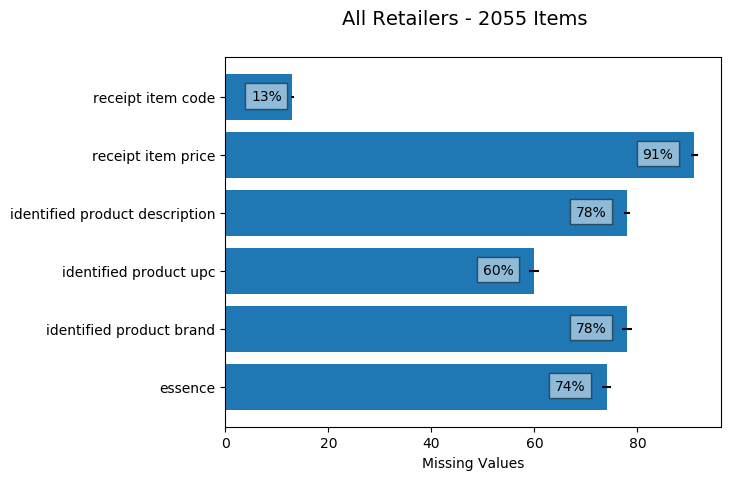

In [5]:
df_items = df.copy()

df_items = df_items[['client_receipt_id',
                     'retailer_name',
                     'receipt_item_code',
                     'receipt_item_price',
                     'identified_product_description',
                     'identified_product_upc',
                     'identified_product_brand',
                     'essence',
#                      'essence_in_item',
#                      'product_price',
                     'product_confidence']]
# df_items['essence_in_item'] = df_items['essence_in_item'].replace('0',np.nan)

df_items.set_index('client_receipt_id',inplace=True)
items = df_items.groupby('client_receipt_id').size().rename('items')
df_items = df_items.join(items)
total_items = items.sum()


df_items_cnt = df_items.count()
df_items_cnt = round((df_items_cnt/total_items)*100).astype(int)



#  Plot % of missing values
plt.rcdefaults()
fig, ax = plt.subplots()
fig.suptitle(('All Retailers - ' + str(total_items) + ' Items'), fontsize=14)



key = df_items_cnt.keys()[1:][:-2]
key = key.str.replace('_',' ').map(lambda x: x.lower())

y_pos = np.arange(len(key))
performance = df_items_cnt[1:][:-2]


error = np.random.rand(len(key))

ax.barh(y_pos, performance.values, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(key)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Missing Values')
# 

for i, v in enumerate(performance.values):
    ax.text(max(5,v-10), i + .05, str(v)+'%', bbox=dict(facecolor='white', alpha=0.5))
    
    
plt.savefig('All_retailers.png', bbox_inches='tight', transparent=True)
plt.show()

 ____________________________________________________________________________________________________________________________

 ____________________________________________________________________________________________________________________________

# Review Identification

In [6]:
df_iden_category = df[['client_receipt_id','retailer_name','receipt_item_description','product_category','identified_product_brand','essence','product_confidence']]
df_iden_category = df_iden_category[df_iden_category['retailer_name']!= 'REWE']
df_iden_category[['client_receipt_id','receipt_item_description','product_category','identified_product_brand','essence','product_confidence']][90:110]

,client_receipt_id,receipt_item_description,product_category,identified_product_brand,essence,product_confidence
93,OOHReceipt_20200110_142136,Coke Zero 1 L PET,LIMONADEN MIT KOHLENSAEURE,FANTA,fanta,0.492
94,OOHReceipt_20200110_142136,PFAND FL PETO.15,NaN,NaN,NaN,NaN
95,OOHReceipt_20200110_142136,Blue Label XXL,LIPPENPFLEGE,LABELLINO,cherryblossom,0.355
96,OOHReceipt_20200114_091101,"Helles Lager 0,2",BIER,SANKT JARO,lagerbier,0.727
97,OOHReceipt_20200114_091101,"Rotbier 0,4",TT MEGA IN/OUT,RESTLICHE MARKEN,rotbier,0.632
98,OOHReceipt_20200115_093519,Apfeltasche,BACKWAREN FRISCHWARE,MEINE KUCHENWELT,apfeltaschen,0.739
99,OOHReceipt_20200114_172444,Latte Macchiato Small,TAFELSCHOKOLADE,CHOCARRE,latte macchiato,0.720
100,OOHReceipt_20200114_160306,Kamps,WURST FRISCH / SB-WARE,KAMPSEN,schinkenkrakauer,0.460
101,OOHReceipt_20200114_160306,Barzahlung,NaN,NaN,NaN,NaN
102,OOHReceipt_20200114_160306,Zahlung EUR,HART-/ SCHNITTKAESE,ALDI,reggiano,0.199


 ____________________________________________________________________________________________________________________________

## Review Extraction Results:


In [7]:
df_extraction = df[['handle_id','client_receipt_id','snapshot_url_1','retailer_name','purchase_date','purchase_time','purchase_total','receipt_item_description','receipt_item_price','receipt_item_quantity']]
df_extraction =  df_extraction[df_extraction['retailer_name'].isnull()]

for rec in df_extraction['client_receipt_id'].unique():
    print('\n\n\n\n\n\n\n')
#     print(rec)
    print(df_extraction[df_extraction['client_receipt_id']==rec].transpose())
    









                                                                                                                                     0
handle_id                 4d0a8b43-b81d-42c9-aa27-76978b745503                                                                        
client_receipt_id         OOHReceipt_20200124_182758                                                                                  
snapshot_url_1            https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200124_182758_1.jpg
retailer_name             NaN                                                                                                         
purchase_date             2020-01-24                                                                                                  
purchase_time             18:26:16                                                                                                    
purchase_total            NaN                  

receipt_item_quantity     1                                                                                                             








                                                                                                                                   154  \
handle_id                 c15aa33f-8683-4568-a56d-3a4ac2514a74                                                                           
client_receipt_id         OOHReceipt_20200115_234531                                                                                     
snapshot_url_1            https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200115_234531_1.jpg   
retailer_name             NaN                                                                                                            
purchase_date             2020-01-15                                                                                                     
purchase_time             2

receipt_item_quantity     1                                                                                                           








                                                                                                                                   411  \
handle_id                 bbcb6c28-7e3a-4e3c-9ac2-6e76fd12769e                                                                           
client_receipt_id         OOHReceipt_20200121_130001                                                                                     
snapshot_url_1            https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200121_130001_1.jpg   
retailer_name             NaN                                                                                                            
purchase_date             2020-01-21                                                                                                     
purchase_time             12:

                                                                                                                                   652  \
handle_id                 788a715c-a11c-49ef-85dc-e0edc5ae51f8                                                                           
client_receipt_id         OOHReceipt_20200121_084340                                                                                     
snapshot_url_1            https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200121_084340_1.jpg   
retailer_name             NaN                                                                                                            
purchase_date             NaN                                                                                                            
purchase_time             NaN                                                                                                            
purchase_total            44.84   

                                                                                                                                   933
handle_id                 58d25808-d521-4d2a-9e85-2eb587a0ddba                                                                        
client_receipt_id         OOHReceipt_20200120_091511                                                                                  
snapshot_url_1            https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200120_091511_1.jpg
retailer_name             NaN                                                                                                         
purchase_date             2020-01-18                                                                                                  
purchase_time             00:01:00                                                                                                    
purchase_total            1.99                         

                                                                                                                                  1254  \
handle_id                 fbbb6316-ed29-44d6-b79a-ccd96c53e93f                                                                           
client_receipt_id         OOHReceipt_20200125_210551                                                                                     
snapshot_url_1            https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200125_210551_1.jpg   
retailer_name             NaN                                                                                                            
purchase_date             2020-01-25                                                                                                     
purchase_time             20:58:07                                                                                                       
purchase_total            NaN     

receipt_item_quantity     1                                                                                                             








                                                                                                                                  1455
handle_id                 7b7f55aa-962f-4677-96f8-605595ec8f5e                                                                        
client_receipt_id         OOHReceipt_20200121_133644                                                                                  
snapshot_url_1            https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200121_133644_1.jpg
retailer_name             NaN                                                                                                         
purchase_date             2020-01-20                                                                                                  
purchase_time             12:12:00           

receipt_item_quantity     1                                                                                                             








                                                                                                                                  1655  \
handle_id                 3939dc09-5c46-408e-9efe-e0e7c3cb168a                                                                           
client_receipt_id         OOHReceipt_20200126_094816                                                                                     
snapshot_url_1            https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200126_094816_1.jpg   
retailer_name             NaN                                                                                                            
purchase_date             2020-01-26                                                                                                     
purchase_time             0









                                                                                                                                  1921
handle_id                 e769061f-0d84-44ea-9a7f-aeb85f4cc84d                                                                        
client_receipt_id         OOHReceipt_20200124_145757                                                                                  
snapshot_url_1            https://s3.amazonaws.com/ourcart.platform.poc/gfk_23_12_19/OutOfHome_batch2/OOHReceipt_20200124_145757_1.jpg
retailer_name             NaN                                                                                                         
purchase_date             2020-01-24                                                                                                  
purchase_time             14:13:00                                                                                                    
purchase_total            5.55                 

 ____________________________________________________________________________________________________________________________

## Category & Essence review:

In [8]:
df[['file','client_receipt_id','retailer_name','receipt_item_description','product_category','essence','product_confidence']].sort_values('product_confidence', ascending=False).iloc[::14]

,file,client_receipt_id,retailer_name,receipt_item_description,product_category,essence,product_confidence
1020,out_of_home2,OOHReceipt_20200122_091830,ROSSMANN,ISANA CREMEBAD,BADEZUSAETZE,NaN,0.990
1016,out_of_home2,OOHReceipt_20200122_140241,NaN,"Salat,To Go",GEMUESE FRISCHWARE,salat,0.950
643,out_of_home2,OOHReceipt_20200120_091530,NaN,Take Off Energy Dr PET,SPORTGETRAENKE FLUESSIG,energy drink,0.950
466,out_of_home2,OOHReceipt_20200119_180012,NaN,Schnitzel Wiener Art,TIEFKUEHLKOST (****),schnitzel,0.950
182,out_of_home2,OOHReceipt_20200116_122944,NaN,"Fritz Kola ohne Zucker 0,331",GETRAENKE GESAMT,kola,0.950
781,out_of_home2,OOHReceipt_20200120_091201,NaN,Milka Noisett 100g,TAFELSCHOKOLADE,noisette,0.929
1545,out_of_home2,OOHReceipt_20200121_221038,NaN,BBQ-Sauce,WUERZSOSSEN / COCKTAILSAUCEN,sauce,0.913
863,out_of_home2,OOHReceipt_20200121_084404,NaN,Coffee to go,NAGELPFLEGE /-KOSMETIK,NaN,0.887
258,out_of_home2,OOHReceipt_20200116_221619,NaN,Samba-Breze,SCHOKORIEGEL / NUSSRIEGEL,samba,0.864
723,out_of_home2,OOHReceipt_20200120_094705,REWE,FELDSALAT BIO,GEMUESE FRISCHWARE,feldsalat,0.851


 ____________________________________________________________________________________________________________________________

# Check Final results for GFK POC:

In [9]:
pd.set_option('display.max_rows', 1000)
df_poc_final = df.copy()[['file','client_receipt_id','snapshot_url_1','retailer_name','receipt_item_description','identified_product_description','product_category','essence','essence_in_item','suspected_brand','identified_product_brand','product_confidence']]
df_poc_final.loc[((df_poc_final['retailer_name'].isna()) | (df_poc_final['product_confidence'] < 0.7)), 'identified_product_description'] = np.nan 
df_poc_final.loc[(df_poc_final['product_confidence']<0.6), 'product_category'] = np.nan 
df_poc_final.loc[(df_poc_final['essence_in_item']!=1), 'essence'] = np.nan 
df_poc_final.loc[(df_poc_final['product_confidence']<0.6), 'identified_product_brand'] = np.nan 




print(df_poc_final.groupby('file').count().transpose())


df_poc_final.to_csv('poc_ooh_b2.csv')
df_poc_final

KeyError: "['suspected_brand'] not in index"